In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=ae13ebedec42b1ee9a220c3d8bf3956c40da4a2e1af04655285b72f836f2d8dc
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
from google.colab import files

In [3]:
uploaded = files.upload()


Saving transactionrecord to transactionrecord


In [7]:
!ls

sample_data  transactionrecord


In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName("TransactionAnalysis").getOrCreate()

In [10]:
df = spark.read.csv('/content/transactionrecord', header=True, inferSchema=True)

In [11]:
df.show(5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

**Quetion 1**

In [12]:
from pyspark.sql.functions import regexp_replace, col, when
from pyspark.sql import functions as F

**1.1.1**

In [13]:
# 1.1.1 Replace 'NA' in CustomerNo column with '-1'
df_cleaned = df.withColumn('CustomerNo', when(col('CustomerNo').isNull(), '-1').otherwise(col('CustomerNo')))

In [14]:
# 1.1.2 Create a new column 'productName_process' that only contains alphabetic characters
# Remove non-alphabetic characters using regexp_replace and store in a new column
df_cleaned = df_cleaned.withColumn('productName_process', regexp_replace(col('ProductName'), '[^a-zA-Z ]', ''))

In [15]:

# Show the first 5 rows to verify the changes
df_cleaned.select('CustomerNo', 'ProductName', 'productName_process').show(5, truncate=False)

+----------+-----------------------------------+-----------------------------------+
|CustomerNo|ProductName                        |productName_process                |
+----------+-----------------------------------+-----------------------------------+
|17490     |Set Of 2 Wooden Market Crates      |Set Of  Wooden Market Crates       |
|13069     |Christmas Star Wish List Chalkboard|Christmas Star Wish List Chalkboard|
|13069     |Storage Tin Vintage Leaf           |Storage Tin Vintage Leaf           |
|13069     |Tree T-Light Holder Willie Winkie  |Tree TLight Holder Willie Winkie   |
|13069     |Set Of 4 Knick Knack Tins Poppies  |Set Of  Knick Knack Tins Poppies   |
+----------+-----------------------------------+-----------------------------------+
only showing top 5 rows



**Question 2**

In [16]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum as _sum

**1.2.1**

In [17]:
# 1.2.1 Calculate Revenue (Price * Quantity)
df_with_revenue = df.withColumn('Revenue', (col('Price') * col('Quantity')).cast('float'))

In [18]:
# Show top 5 rows to verify Revenue calculation
df_with_revenue.select('Date', 'Price', 'Quantity', 'Revenue').show(5)

+---------+-----+--------+-------+
|     Date|Price|Quantity|Revenue|
+---------+-----+--------+-------+
|12/9/2019|21.47|      12| 257.64|
|12/9/2019|10.65|      36|  383.4|
|12/9/2019|11.53|      12| 138.36|
|12/9/2019|10.65|      12|  127.8|
|12/9/2019|11.94|       6|  71.64|
+---------+-----+--------+-------+
only showing top 5 rows



**1.2.2**

In [19]:
# 1.2.2 Convert PySpark DataFrame to Pandas DataFrame
# First, collect PySpark DataFrame to Pandas
df_pandas = df_with_revenue.toPandas()

In [20]:
# Convert 'Date' to datetime format in Pandas and create 'transaction_date' column
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'], dayfirst=True, errors='coerce')

In [21]:
# Show the top 5 rows in Pandas DataFrame to verify
print(df_pandas[['Date', 'transaction_date']].head())

        Date transaction_date
0  12/9/2019       2019-09-12
1  12/9/2019       2019-09-12
2  12/9/2019       2019-09-12
3  12/9/2019       2019-09-12
4  12/9/2019       2019-09-12


**1.2.3**

In [22]:
# 1.2.3 Plot the Sum of Revenue on Transaction Date
# Group by 'transaction_date' and sum the revenue
df_grouped = df_pandas.groupby('transaction_date')['Revenue'].sum().reset_index()

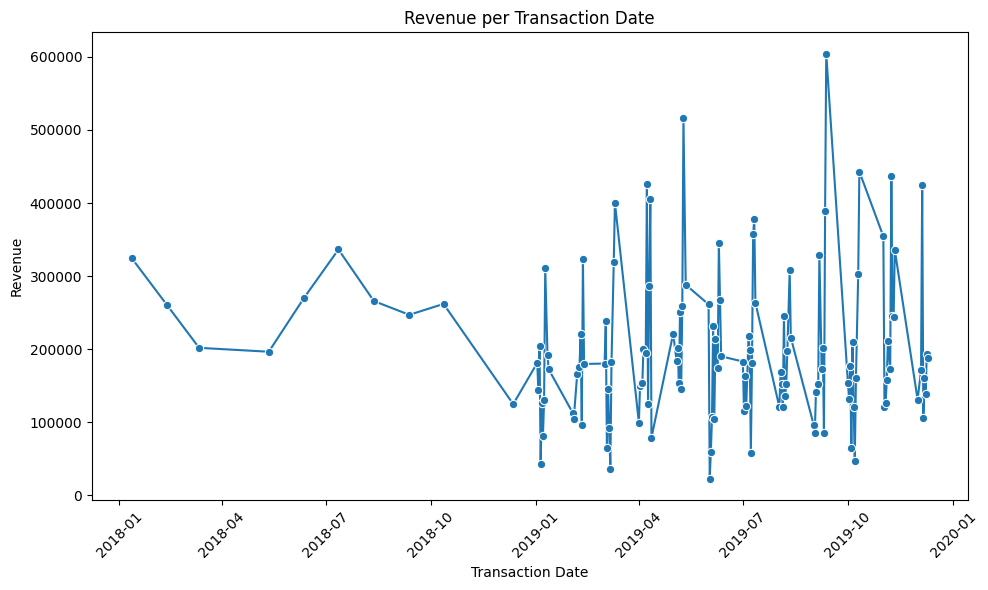

In [23]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='transaction_date', y='Revenue', data=df_grouped, marker='o')
plt.title('Revenue per Transaction Date')
plt.xlabel('Transaction Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Immediate insight**

The revenue plot shows an initial decline, followed by fluctuations that stabilize. High volatility is observed, with several peaks and troughs suggesting inconsistent daily revenue. Significant spikes in the middle and end likely result from promotional events or seasonal demand. Towards the end, revenue stabilizes within a consistent range, indicating potential market or customer behavior normalization after earlier fluctuations.

**Question 1.3**

**1.3.1**

In [24]:
# Import necessary functions
from pyspark.sql.functions import dayofweek, col, avg

In [26]:
# chacking if transaction_date exists
print(df_pandas[['Date', 'transaction_date']].head())

        Date transaction_date
0  12/9/2019       2019-09-12
1  12/9/2019       2019-09-12
2  12/9/2019       2019-09-12
3  12/9/2019       2019-09-12
4  12/9/2019       2019-09-12


In [27]:
# converting pandas df to pyspark df
spark_df = spark.createDataFrame(df_pandas)

In [28]:
# Checking  transaction_date in PySpark df
spark_df.printSchema()

root
 |-- TransactionNo: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- ProductNo: string (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- Product_category: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- CustomerNo: long (nullable = true)
 |-- Country: string (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- transaction_date: timestamp (nullable = true)



In [29]:
# Add 'workday' column to indicate day of the week
spark_df_with_day = spark_df.withColumn('workday', dayofweek(col('transaction_date')))

In [30]:
# Calculate 'Revenue' by multiplying 'Price' and 'Quantity', and group by 'workday' to get average revenue
spark_df_grouped_workday = spark_df_with_day.withColumn('Revenue', col('Price') * col('Quantity')) \
                                            .groupBy('workday') \
                                            .agg(avg('Revenue').alias('Average_Revenue')) \
                                            .orderBy('workday')

In [31]:
#Convert the result to a Pandas DataFrame for easier plotting
df_workday_pandas = spark_df_grouped_workday.toPandas()

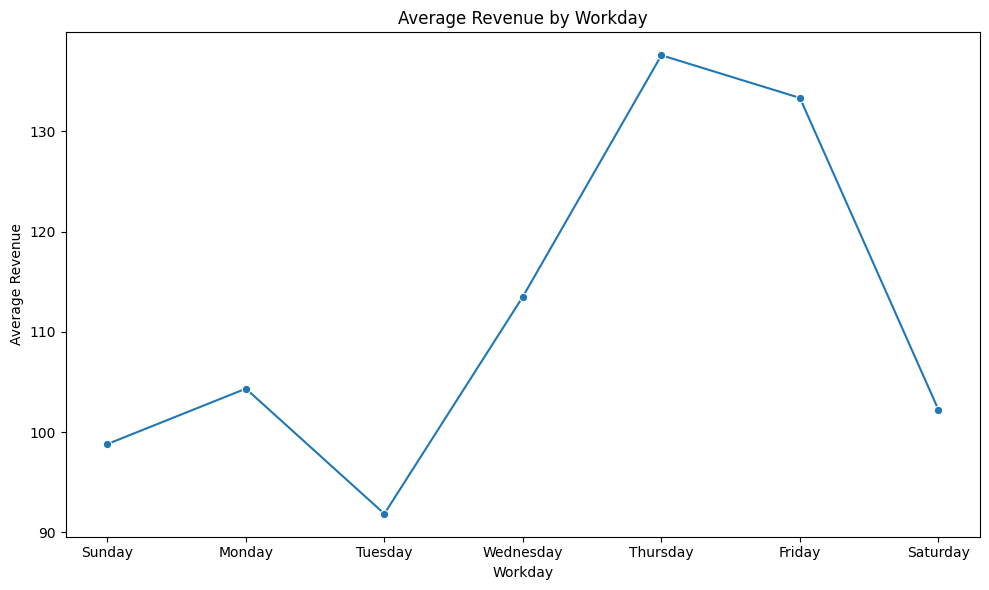

In [32]:
#  Plot the average revenue by workday
plt.figure(figsize=(10, 6))
sns.lineplot(x='workday', y='Average_Revenue', data=df_workday_pandas, marker='o')

# Customize the plot
plt.title('Average Revenue by Workday')
plt.xlabel('Workday')
plt.ylabel('Average Revenue')

# Set x-axis ticks and labels to represent the days of the week
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7],
           labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

# Adjust the layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

1.3.2

In [33]:
# Find the workday with the highest average revenue
max_revenue_workday = spark_df_grouped_workday.orderBy(col('Average_Revenue').desc()).first()['workday']

In [34]:
# Recreating 'productName_process' by removing non-alphabetic characters
spark_df_with_day = spark_df_with_day.withColumn('productName_process', regexp_replace(col('ProductName'), '[^a-zA-Z ]', ''))

In [35]:
# filter the data for that specific workday (as before)
df_filtered = spark_df_with_day.filter(col('workday') == max_revenue_workday)

In [36]:
# Identify the product with the highest revenue on that workday
df_highest_revenue_product = df_filtered.groupBy('productName_process') \
                                        .agg(_sum('Revenue').alias('Total_Revenue')) \
                                        .orderBy(col('Total_Revenue').desc())

In [37]:
# Get the product name with the highest revenue
highest_revenue_product = df_highest_revenue_product.first()['productName_process']

In [38]:
# Identify the product with the highest sales volume (sum of Quantity) on that workday
df_highest_sales_product = df_filtered.groupBy('productName_process') \
                                      .agg(_sum('Quantity').alias('Total_Quantity')) \
                                      .orderBy(col('Total_Quantity').desc())

In [39]:
# Get the product name with the highest sales volume
highest_sales_volume_product = df_highest_sales_product.first()['productName_process']

In [40]:
# Display the results
print(f"Workday with the highest average revenue: {max_revenue_workday}")
print(f"Product with the highest revenue: {highest_revenue_product}")
print(f"Product with the highest sales volume: {highest_sales_volume_product}")

Workday with the highest average revenue: 5
Product with the highest revenue: Paper Craft Little Birdie
Product with the highest sales volume: Popcorn Holder


**1.3.3**

In [41]:
# Calculate total revenue for each product
df_total_revenue = spark_df_with_day.groupBy('productName_process') \
                                    .agg(_sum('Revenue').alias('Total_Revenue')) \
                                    .orderBy(col('Total_Revenue').desc())

In [42]:
# Convert to Pandas DataFrame for plotting
df_total_revenue_pandas = df_total_revenue.limit(5).toPandas()

In [43]:
# Calculate total sales volume (sum of Quantity) for each product
df_total_sales_volume = spark_df_with_day.groupBy('productName_process') \
                                         .agg(_sum('Quantity').alias('Total_Quantity')) \
                                         .orderBy(col('Total_Quantity').desc())

In [44]:
# Convert to Pandas DataFrame for plotting
df_total_sales_volume_pandas = df_total_sales_volume.limit(5).toPandas()

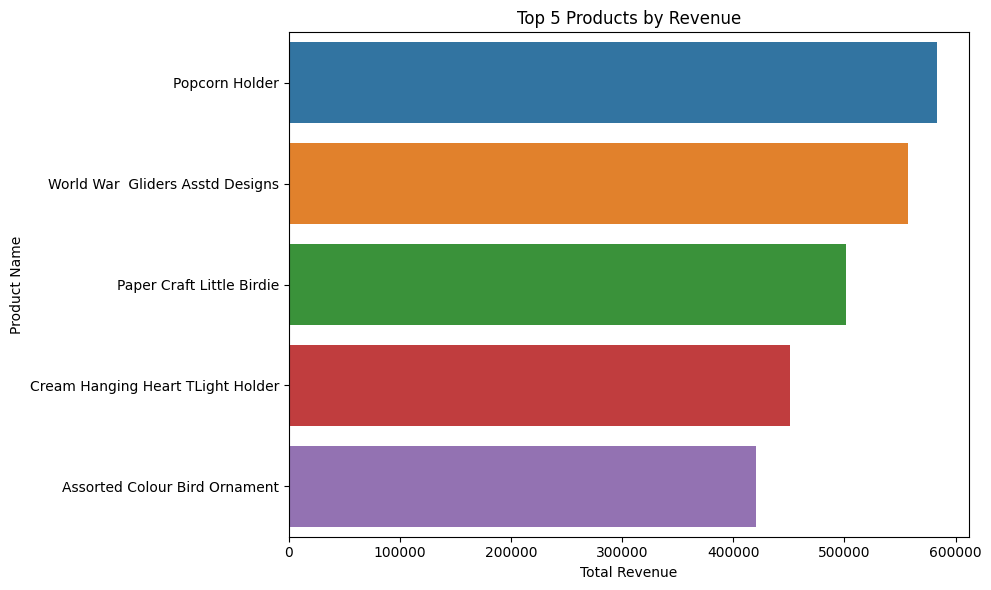

In [45]:
# Plot the top 5 products with the highest revenue
plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Revenue', y='productName_process', data=df_total_revenue_pandas, hue='productName_process', dodge=False, legend=False)
plt.title('Top 5 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

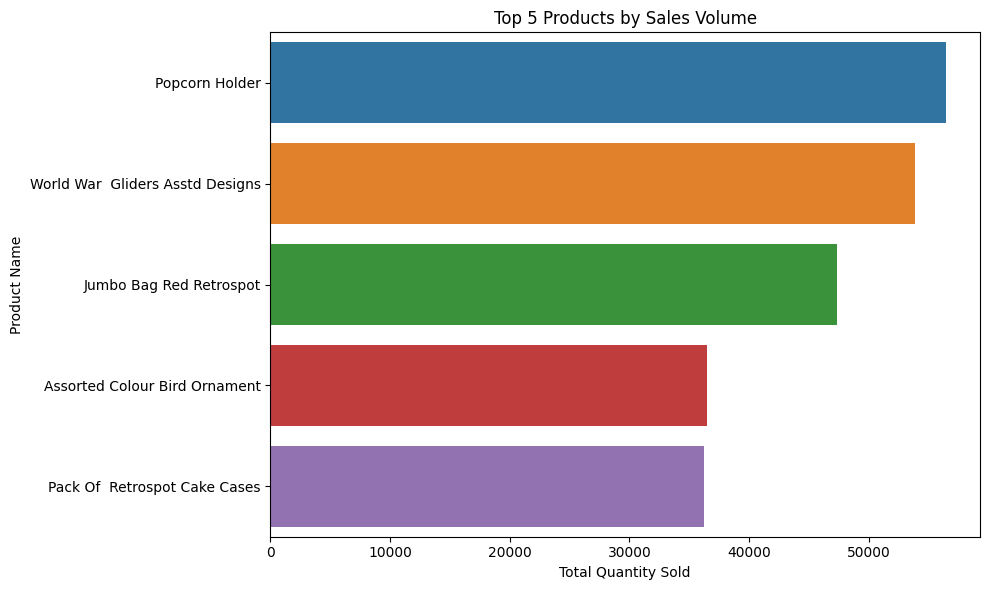

In [46]:
# Plot the top 5 products with the highest sales volume
plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Quantity', y='productName_process', data=df_total_sales_volume_pandas, hue='productName_process', dodge=False, legend=False)
plt.title('Top 5 Products by Sales Volume')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

**Question 4**

In [47]:
from pyspark.sql.functions import month, col
from pyspark.sql.functions import to_date, col

In [48]:
spark_df_with_day = spark_df.withColumn('transaction_date', to_date(col('Date'), 'MM/dd/yyyy'))

In [49]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [50]:
# Group by 'Country' and calculate total revenue for each country
df_country_revenue = spark_df_with_day.groupBy('Country') \
                                      .agg(_sum('Revenue').alias('Total_Revenue')) \
                                      .orderBy(col('Total_Revenue').desc())

In [51]:
# Get the country with the highest total revenue
highest_revenue_country = df_country_revenue.first()['Country']
print(f"Country with the highest total revenue: {highest_revenue_country}")

Country with the highest total revenue: United Kingdom


In [52]:
# Filter the data for that country
df_country_filtered = spark_df_with_day.filter(col('Country') == highest_revenue_country)

In [53]:
# Add a 'month' column to the DataFrame
df_country_filtered = df_country_filtered.withColumn('month', month(col('transaction_date')))

In [54]:
# Group by 'month' and calculate total revenue for each month in that country
df_month_revenue = df_country_filtered.groupBy('month') \
                                      .agg(_sum('Revenue').alias('Total_Revenue')) \
                                      .orderBy(col('Total_Revenue').desc())

In [55]:
# Get the month with the highest total revenue in that country
highest_revenue_month = df_month_revenue.first()['month']
print(f"Month with the highest revenue in {highest_revenue_country}: {highest_revenue_month}")

Month with the highest revenue in United Kingdom: 11


**1.5**

In [56]:
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import sum as _sum

In [57]:
# Filter out transactions where Quantity <= 0
df_filtered_shopping = spark_df.filter(col('Quantity') > 0)

In [58]:
# Count distinct transactions for each customer
df_customer_transaction_count = df_filtered_shopping.groupBy('CustomerNo') \
    .agg(countDistinct('TransactionNo').alias('Distinct_Transaction_Count'))

In [59]:
# Show the result to verify
df_customer_transaction_count.show()

+----------+--------------------------+
|CustomerNo|Distinct_Transaction_Count|
+----------+--------------------------+
|     17703|                         4|
|     13098|                        28|
|     13638|                         1|
|     17048|                         3|
|     16597|                         1|
|     16896|                         1|
|     15237|                         5|
|     15194|                        15|
|     17043|                         4|
|     14719|                         6|
|     13460|                         3|
|     15322|                         1|
|     13518|                         2|
|     15432|                         1|
|     18147|                         2|
|     17979|                         4|
|     13248|                         2|
|     16530|                         1|
|     18196|                         2|
|     15663|                         1|
+----------+--------------------------+
only showing top 20 rows



In [60]:
# Find the customer with the highest count of distinct transactions
highest_frequency_customer = df_customer_transaction_count.orderBy(col('Distinct_Transaction_Count').desc()).first()['CustomerNo']
print(f"Customer with the highest frequency of transactions: {highest_frequency_customer}")

Customer with the highest frequency of transactions: 12748


In [61]:
# Filter transactions for the customer with the highest frequency
df_customer_products = df_filtered_shopping.filter(col('CustomerNo') == highest_frequency_customer)

In [62]:
# Recreating 'productName_process' by removing non-alphabetic characters
df_customer_products = df_customer_products.withColumn('productName_process',
    regexp_replace(col('ProductName'), '[^a-zA-Z ]', ''))

In [63]:
# Aggregate the quantity of products purchased
df_customer_product_summary = df_customer_products.groupBy('productName_process') \
    .agg(_sum('Quantity').alias('Total_Quantity')) \
    .orderBy(col('Total_Quantity').desc())

In [64]:
# Show the result to verify
df_customer_product_summary.show()

+--------------------+--------------+
| productName_process|Total_Quantity|
+--------------------+--------------+
|Victorian Metal P...|           595|
|World War  Glider...|           480|
|Rose Scent Candle...|           408|
|Cartoon Pencil Sh...|           405|
|Small White Retro...|           390|
|Vanilla Scent Can...|           380|
|Small Red Retrosp...|           372|
|Bubblegum Ring As...|           318|
|Popart Wooden Pen...|           300|
|Ocean Scent Candl...|           225|
|Assorted Creepy C...|           216|
|Pens Assorted Fun...|           216|
|      Garage Key Fob|           174|
|Marie Antoinette ...|           168|
|        Key Fob Shed|           164|
|  Brocade Ring Purse|           158|
|Wrap Christmas Sc...|           150|
|Jazz Hearts Purse...|           147|
|      Popcorn Holder|           147|
|Beaded Chandelier...|           144|
+--------------------+--------------+
only showing top 20 rows



**Question 6**

**1.6.1**

In [65]:
from pyspark.sql.functions import col

In [66]:
# Filter the DataFrame to include only rows with Quantity > 0
df_filtered = df.filter(col('Quantity') > 0)

In [67]:
from pyspark.sql.functions import collect_list

In [68]:
# Recreating 'productName_process' by removing non-alphabetic characters
df_filtered = df_filtered.withColumn('productName_process', regexp_replace(col('ProductName'), '[^a-zA-Z ]', ''))

In [69]:
# Group by 'TransactionNo' and aggregate 'product_category' and 'productName_process' into lists
df_basket_analysis = df_filtered.groupBy('TransactionNo') \
    .agg(
        collect_list('Product_category').alias('product_categories'),
        collect_list('productName_process').alias('product_names')
    )

In [70]:
# Show the result
df_basket_analysis.show(truncate=False)

+-------------+--------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TransactionNo|product_categories               

**1.6.2**

In [71]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType

In [72]:
# Define the UDF to remove adjacent duplicates
def remove_adjacent_duplicates(lst):
    if not lst:
        return []
    result = [lst[0]]
    for item in lst[1:]:
        if item != result[-1]:
            result.append(item)
    return result

In [73]:
# Register the UDF with Spark
remove_adjacent_duplicates_udf = udf(remove_adjacent_duplicates, ArrayType(StringType()))

In [74]:
# Apply the UDF to the DataFrame
df_1 = df_basket_analysis.withColumn('product_categories', remove_adjacent_duplicates_udf(col('product_categories')))

In [75]:
# Show the top 10 rows of the processed DataFrame
df_1.show(10, truncate=False)

+-------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TransactionNo|product_categories|product_names                                                                                                                                                                                                                                                                                                                                                                                                                                   

**Question 1.7**

**1.7.1**

In [76]:
from pyspark.sql.functions import size

In [77]:
# Add a new column 'prod_len' to calculate the length of the 'product_categories' list
df_1 = df_1.withColumn('prod_len', size('product_categories'))

In [78]:
# Show the first five rows of the updated DataFrame
df_1.show(5, truncate=False)

+-------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|TransactionNo|product_categories|product_names                                                                                                                                                                                                                                                                                                                                                                                                                          

**1.7.2**

In [80]:
from pyspark.sql.functions import col, udf, array_join

In [81]:
from pyspark.sql.types import StringType

In [82]:
# Define the function to process data
def data_processing(df, maxlength=3, minlength=1):
    # Filter the dataframe based on prod_len
    df_filtered = df.filter((col('prod_len') <= maxlength) & (col('prod_len') >= minlength))

    # Define a UDF to transform the list
    def transform_list(categories):
        if categories:
            return 'start > ' + ' > '.join(categories) + ' > conversion'
        else:
            return 'start > conversion'

    # Register the UDF
    transform_udf = udf(transform_list, StringType())

    # Apply the UDF to create the 'path' column
    df_transformed = df_filtered.withColumn('path', transform_udf(col('product_categories')))

    return df_transformed

In [83]:
# Run the function with df_1
df_2 = data_processing(df_1, maxlength=5, minlength=2)

In [84]:
# Print the top 10 rows of df_2
df_2.show(2, truncate=False)

+-------------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+------------------------------------------------+
|TransactionNo|product_categories       |product_names                                                   